<h1> Trading Strategy Using Classification <h1>

The key steps involved in creating the strategy are:
1. Read data
2. Create indicators
3. Calculate returns
4. Train and test data
5. Create output signals
6. Base model comparison
7. Hyperparameter tuning
8. Model evaluation
9. Predict the signals
10. Analyse the performance
11. Plot the results

# Load libraries and data


<a id='Import the libraries'></a>


In [1]:
!pip install pandas_ta

In [2]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Technical indicator library
import pandas_ta as ta

# Download price from yahoo finance
import yfinance as yf

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'PLTR'

# Download price data
Df = yf.download(ticker, start='2019-01-01',
                               multi_level_index=False,
                               auto_adjust=True)

# Display the first 5 rows
Df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-09-30,9.50,11.41,9.11,10.00,338584400
2020-10-01,9.46,10.10,9.23,9.69,124297600
2020-10-02,9.20,9.28,8.94,9.06,55018300
2020-10-05,9.03,9.49,8.92,9.43,36316900
2020-10-06,9.90,10.18,8.90,9.04,90864000


In [4]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1126 entries, 2020-09-30 to 2025-03-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1126 non-null   float64
 1   High    1126 non-null   float64
 2   Low     1126 non-null   float64
 3   Open    1126 non-null   float64
 4   Volume  1126 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 52.8 KB


# Feature creation

## Create indcators

* `Relative Strength Index (RSI)`
  * a momentum oscillator that measures the speed and change of price movements.


* `Simple Moving Average (SMA)`
  * a trend-following indicator that smooths price fluctuations.


* `Correlation between SMA and Close price (CORR)`
  * measures trend strength and confirmation.


* `Parabolic SAR - Stop and Reverse (PSAR)`
  * a trend-following indicator that signals potential reversals.


* `Average Directional Index (ADX)`
  * a trend strength indicator measuring the momentum of a trend.

* `Previous period's High, Low, and Close prices`
  * useful for identifying support and resistance levels.

* `Gap-up/down indicator (Open-Open)`
  * the difference between the current period's open and the previous period's open.


* `Bullish/bearish sentiment indicator (Open-Close)`
  * the difference between the current period's open and the previous period's close.



In [5]:
n = 5

# Create RSI indicator (momentum oscillator)
Df['RSI'] = ta.rsi(Df['Close'].shift(1), length=n)

# Create SMA indcator (trend indicator/direction)
Df['SMA'] = Df['Close'].shift(1).rolling(window=n).mean()

# Create correlation between SMA & Close (trend strength)
Df['Corr'] = Df['Close'].shift(1).rolling(window=n).corr(Df['SMA'].shift(1))

# Create SAR indicator (trend reversal)
psar = ta.psar(Df['High'].shift(1), Df['Low'].shift(1), af=0.02, step=0.02)
Df['SAR'] = psar.iloc[:, 0]

# Create ADX indicator (trend strength)
adx = ta.adx(Df['High'].shift(1), Df['Low'].shift(1), Df['Close'].shift(1), length=n)
Df['ADX'] = adx.iloc[:,0]

# Create prev_high, prev_low and prev_close (support/resistance)
Df['Prev_High'] = Df['High'].shift(1)
Df['Prev_Low'] = Df['Low'].shift(1)
Df['Prev_Close'] = Df['Close'].shift(1)

# Create 'OO', difference between the current's open and previous's open (gap-up/down)
Df['OO'] = Df['Open']-Df['Open'].shift(1)

# Create 'OC', difference between the current's open and previous's close (bullish/bearish sentiment)
Df['OC'] = Df['Open']-Df['Prev_Close']

Df

,Close,High,Low,Open,Volume,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,OO,OC
Date,,,,,,,,,,,,,,,
2020-09-30,9.500000,11.410000,9.110000,10.000000,338584400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,9.460000,10.100000,9.230000,9.690000,124297600,NaN,NaN,NaN,NaN,NaN,11.410000,9.110000,9.500000,-0.310000,0.190000
2020-10-02,9.200000,9.280000,8.940000,9.060000,55018300,NaN,NaN,NaN,9.110000,NaN,10.100000,9.230000,9.460000,-0.629999,-0.400000
2020-10-05,9.030000,9.490000,8.920000,9.430000,36316900,NaN,NaN,NaN,9.110000,NaN,9.280000,8.940000,9.200000,0.370000,0.230000
2020-10-06,9.900000,10.180000,8.900000,9.040000,90864000,NaN,NaN,NaN,8.940000,NaN,9.490000,8.920000,9.030000,-0.390000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-19,86.099998,87.989998,82.860001,84.550003,89797400,48.682400,84.150000,-0.101514,82.160004,25.925570,86.169998,81.800003,83.889999,-1.229996,0.660004
2025-03-20,87.389999,89.800003,85.120003,85.540001,105547400,54.744092,84.639999,0.164740,81.800003,22.287789,87.989998,82.860001,86.099998,0.989998,-0.559998
2025-03-21,90.959999,91.070000,84.459999,85.849998,116748700,58.335019,86.193999,-0.072162,81.800003,22.259475,89.800003,85.120003,87.389999,0.309998,-1.540001


## Calculate returns

* `Future returns`
  * calculated base on next period opening price.
  * Often used in predictive modeling for financial time series analysis, where we try to forecast the next period’s return.


* `Lagged series return`
  * store historical past return.
  * allow models (reg or NN) to analyze historical historical returns.

In [6]:
# Create 'Fut_Ret' (next day return)
Df['Fut_Ret'] = (Df['Open'].shift(-1) - Df['Open'])/Df['Open']

# Create a series of lagged return
for i in range(1, 5):
    Df['return%i' % i] = Df['Fut_Ret'].shift(i)

# Drop the NaN values
Df = Df.dropna()
Df

,Close,High,Low,Open,Volume,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,OO,OC,Fut_Ret,return1,return2,return3,return4
Date,,,,,,,,,,,,,,,,,,,,
2020-10-14,9.340000,9.660000,9.290000,9.600000,13652600,34.988916,9.862000,-0.881591,9.660000,38.357641,9.880000,9.410000,9.470000,-0.280000,0.130000,-0.034375,-0.028340,-0.015936,-0.008885,-0.015549
2020-10-15,9.910000,9.910000,9.180000,9.270000,12924100,29.793375,9.730000,-0.857084,9.410000,35.257669,9.660000,9.290000,9.340000,-0.330000,-0.070000,0.072276,-0.034375,-0.028340,-0.015936,-0.008885
2020-10-16,9.710000,9.950000,9.660000,9.940000,11142500,61.294012,9.712000,-0.842940,9.290000,27.844589,9.910000,9.180000,9.910000,0.669999,0.030000,-0.015091,0.072276,-0.034375,-0.028340,-0.015936
2020-10-19,9.570000,9.820000,9.530000,9.790000,9126400,51.215283,9.664000,-0.756887,9.180000,23.700005,9.950000,9.660000,9.710000,-0.150000,0.080000,-0.019408,-0.015091,0.072276,-0.034375,-0.028340
2020-10-20,9.270000,9.660000,9.270000,9.600000,11138200,44.773341,9.600000,-0.604619,9.180000,20.037769,9.820000,9.530000,9.570000,-0.190000,0.030001,-0.031250,-0.019408,-0.015091,0.072276,-0.034375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-18,83.889999,86.169998,81.800003,85.779999,93236500,58.495736,82.982001,-0.630424,78.320000,30.306222,88.820000,84.500000,87.349998,-2.660004,-1.570000,-0.014339,-0.030077,0.065927,0.001509,-0.007607
2025-03-19,86.099998,87.989998,82.860001,84.550003,89797400,48.682400,84.150000,-0.101514,82.160004,25.925570,86.169998,81.800003,83.889999,-1.229996,0.660004,0.011709,-0.014339,-0.030077,0.065927,0.001509
2025-03-20,87.389999,89.800003,85.120003,85.540001,105547400,54.744092,84.639999,0.164740,81.800003,22.287789,87.989998,82.860001,86.099998,0.989998,-0.559998,0.003624,0.011709,-0.014339,-0.030077,0.065927


<a id='Split the data into train and test'></a>
## Train Test split



In [7]:
# Define the split percentage
split_percentage = 0.8
split = int(split_percentage*len(Df))

train_index = Df.iloc[:split].index
test_index = Df.iloc[split:].index

## Create output signals

Create sign 3 signals based on:
* Highest returns’ quantile is assigned `Signal` 1 or Buy.
* Middle quantile is assigned `Signal` 0 or do nothing.
* Lowest quantile is assigned `Signal` -1 or Sell.


In [8]:
# Create 'Signal' and initialise with 0
Df['Signal'] = 0

# Assign a value of 1 if future return is in the top 34%
Df.loc[Df['Fut_Ret'] > Df['Fut_Ret'][train_index].quantile(q=0.66), 'Signal'] = 1

# Assign a value of -1 if future return is in the bottom 34%
Df.loc[Df['Fut_Ret'] < Df['Fut_Ret'][train_index].quantile(q=0.34), 'Signal'] = -1

In [9]:
# drop missing values
Df.dropna(inplace=True)

## Identify features and target

Drop the columns `Close`, `Signal`, `Time`, `High`, `Low`, `Volume`, and `Fut_Ret` since the algorithm will not be trained on these features. Next, we assign `Signal` to `y` which is the output variable that you will predict using test data.   

In [10]:
# Features selected for classification model
X = Df.drop(['Close', 'Signal', 'High',
             'Low', 'Volume', 'Fut_Ret'], axis=1)

# Create target features with top and bottom 34% signals
y = Df['Signal']

In [11]:
y.value_counts()

,count
Signal,
1,394
0,366
-1,355


In [12]:
X.head()

,Open,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,OO,OC,return1,return2,return3,return4
Date,,,,,,,,,,,,,,,
2020-10-14,9.60,34.988916,9.862,-0.881591,9.66,38.357641,9.88,9.41,9.47,-0.280000,0.130000,-0.028340,-0.015936,-0.008885,-0.015549
2020-10-15,9.27,29.793375,9.730,-0.857084,9.41,35.257669,9.66,9.29,9.34,-0.330000,-0.070000,-0.034375,-0.028340,-0.015936,-0.008885
2020-10-16,9.94,61.294012,9.712,-0.842940,9.29,27.844589,9.91,9.18,9.91,0.669999,0.030000,0.072276,-0.034375,-0.028340,-0.015936
2020-10-19,9.79,51.215283,9.664,-0.756887,9.18,23.700005,9.95,9.66,9.71,-0.150000,0.080000,-0.015091,0.072276,-0.034375,-0.028340
2020-10-20,9.60,44.773341,9.600,-0.604619,9.18,20.037769,9.82,9.53,9.57,-0.190000,0.030001,-0.019408,-0.015091,0.072276,-0.034375


# Classification



## Base model comparison

LR: Mean Accuracy = 0.332, Std = 0.015
LDA: Mean Accuracy = 0.330, Std = 0.020
k-NN: Mean Accuracy = 0.325, Std = 0.032
SVM: Mean Accuracy = 0.325, Std = 0.022
NB: Mean Accuracy = 0.377, Std = 0.030
DT: Mean Accuracy = 0.359, Std = 0.012
RFC: Mean Accuracy = 0.325, Std = 0.022
GBC: Mean Accuracy = 0.301, Std = 0.025
Ada: Mean Accuracy = 0.308, Std = 0.015


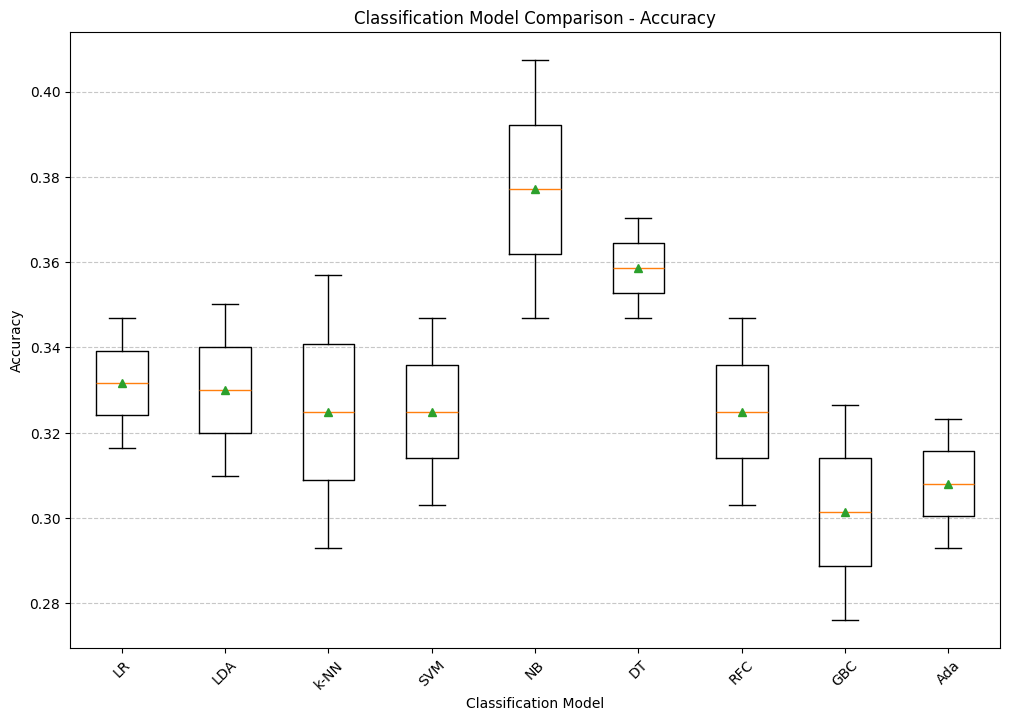


Execution Time: 9.32 seconds


In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Start Execution Timer
start_time = time.time()

# Define base models in a dictionary
models = {
    'LR': LogisticRegression(max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(),
    'k-NN': KNeighborsClassifier(),
    'SVM': SVC(kernel='rbf'),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'RFC': RandomForestClassifier(n_estimators=100),
    'GBC': GradientBoostingClassifier(n_estimators=100),
    'Ada': AdaBoostClassifier(n_estimators=100)
}

# Apply Scaler only to models that need it
scaled_models = ['LR', 'LDA', 'k-NN', 'SVM']
for key in scaled_models:
    models[key] = Pipeline([('scaler', StandardScaler()), (key, models[key])])

# Define Time Series Cross-Validation
n_splits = min(2, len(X.loc[train_index]) // 5)  # Ensure we have enough data for splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Evaluate each model
results = []
model_names = []
for name, model in models.items():
    scores = cross_val_score(model, X.loc[train_index], y.loc[train_index], cv=tscv, scoring='accuracy')
    results.append(scores)
    model_names.append(name)
    print(f'{name}: Mean Accuracy = {scores.mean():.3f}, Std = {scores.std():.3f}')


# # Plot Results
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=model_names, showmeans=True)
plt.title('Classification Model Comparison - Accuracy')
plt.xlabel('Classification Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Execution Time
end_time = time.time()
print(f"\nExecution Time: {end_time - start_time:.2f} seconds")


# SVC

## Hyperparameter tuning

In [14]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Define time series cross-validation
n_splits = min(2, len(X.loc[train_index]) // 5)  # Ensure enough splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the Pipeline
steps = [
    ('scaler', StandardScaler()),
    ('svc', SVC())
]
pipeline = Pipeline(steps)

# Define the hyperparameter grid
# param_grid = {'NB__var_smoothing': np.logspace(-10, -1, 50)}
param_grid = {'svc__C': [10, 100, 1000, 10000],
              'svc__gamma': [1e-2, 1e-1, 1e0],
              'svc__kernel': ['rbf']
              }

# Perform GridSearchCV with time series cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=tscv,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the model with training data
grid_search.fit(X.loc[train_index], y.loc[train_index])

# Retrieve best estimator
best_model = grid_search.best_estimator_

# Display best parameters and best accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Apply best model to make predictions
yhat_train = best_model.predict(X.loc[train_index])
yhat_test = best_model.predict(X.loc[test_index])

# Store prediction in column 'Pred_Signal'
df_svc = Df.copy()
df_svc['Pred_Signal'] = 0
df_svc.loc[train_index, 'Pred_Signal'] = yhat_train
df_svc.loc[test_index, 'Pred_Signal'] = yhat_test
df_svc['strategy_returns'] = df_svc['Fut_Ret'] * df_svc['Pred_Signal']

Best Hyperparameters: {'svc__C': 1000, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Accuracy: 0.35690235690235694


In [15]:
pd.DataFrame({'Signal': df_svc['Signal'].value_counts(),
              'Pred_Signal': df_svc['Pred_Signal'].value_counts()})

,Signal,Pred_Signal
-1,355,361
0,366,333
1,394,421


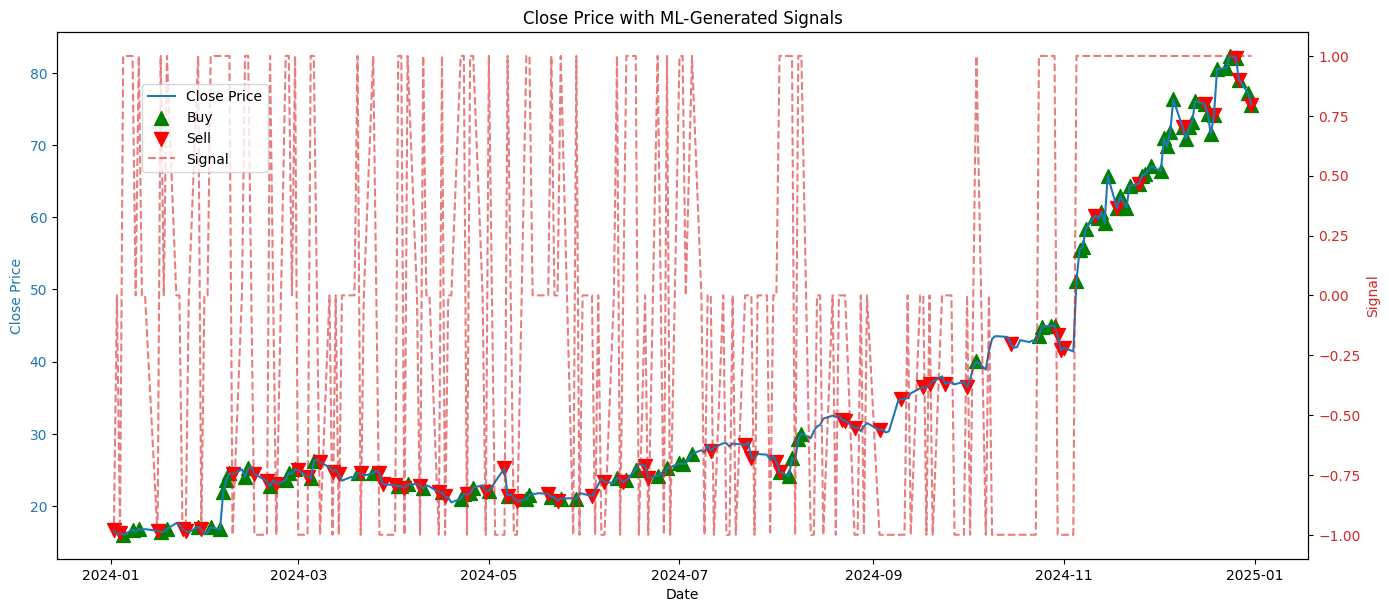

In [16]:
import matplotlib.pyplot as plt

def plot_signal_generation(df):
    # Assuming df has a datetime index, or a 'Date' column set as index
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot close price on left y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], color='tab:blue', label='Close Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create second y-axis for signal
    ax2 = ax1.twinx()
    ax2.set_ylabel('Signal', color='tab:red')
    ax2.plot(df.index, df['Pred_Signal'], color='tab:red', label='Signal', linestyle='--', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Optional: Add buy/sell markers if signal is discrete
    buy_signal = df[df['Pred_Signal'] == 1]
    sell_signal = df[df['Signal'] == -1]
    ax1.scatter(buy_signal.index, buy_signal['Close'], marker='^', color='green', label='Buy', s=100)
    ax1.scatter(sell_signal.index, sell_signal['Close'], marker='v', color='red', label='Sell', s=100)

    fig.tight_layout()
    plt.title('Close Price with ML-Generated Signals')
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.show()


plot_signal_generation(df_svc.loc['2024'])

## Model evaluation

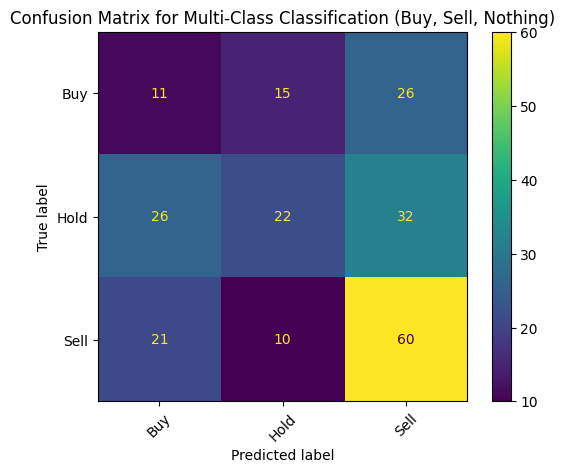

              precision    recall  f1-score   support

          -1       0.19      0.21      0.20        52
           0       0.47      0.28      0.35        80
           1       0.51      0.66      0.57        91

    accuracy                           0.42       223
   macro avg       0.39      0.38      0.37       223
weighted avg       0.42      0.42      0.41       223



In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_confusion_matrix(actual, prediction):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Define class label
    class_labels = ['Buy', 'Hold', 'Sell']

    # Confusion matrix
    cm = confusion_matrix(actual, prediction)

    # Display Confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(xticks_rotation=45)
    plt.title("Confusion Matrix for Multi-Class Classification (Buy, Sell, Nothing)")
    plt.show()

    # Classification Report
    print(classification_report(actual, prediction))


plot_confusion_matrix(y.loc[test_index], yhat_test)

## Strategy implementation

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def analyse_strategy(data, test_index):
    data = data.loc[test_index]
    strategy_ret = data['strategy_returns'].dropna()
    market_ret = data['Fut_Ret'].dropna()

    # Calculate Sharpe Ratio
    sharpe_ratio = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252)

    # Calculate Cumulative returns
    cumulative_returns = (strategy_ret + 1).cumprod()

    # Calculate Drawdown
    running_max = cumulative_returns.cummax()
    drawdown = 100 * (cumulative_returns / running_max - 1)
    max_dd = drawdown.min()

    # Print stats
    print(f"The Sharpe Ratio is {sharpe_ratio:.2f}")
    print(f"Cumulative Return: {(cumulative_returns.iloc[-1] - 1) * 100:.2f}%")
    print(f"Maximum Drawdown: {max_dd:.2f}%")

    # Plot cumulative returns & drawdown
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

    ax1.plot(cumulative_returns, color='blue', label='Strategy')
    ax1.set_title('Cumulative Returns')
    ax1.set_ylabel('Cumulative Returns')
    ax1.legend()

    ax2.plot(drawdown, color='red', label='Drawdown')
    ax2.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
    ax2.set_title('Strategy Drawdown (%)')
    ax2.set_ylabel('Drawdown (%)')
    ax2.set_xlabel('Date')
    ax2.legend()

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Plot market vs strategy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cumulative_returns, label="Strategy Returns", color='blue')
    ax.plot((market_ret + 1).cumprod(), label="Market Returns", linestyle='--', color='gray')
    ax.set_title('Strategy Returns vs Market Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Final return
    return_strategy = (cumulative_returns.iloc[-1] - 1) * 100
    print(f"The strategy return is {return_strategy:.2f}%")


The Sharpe Ratio is 1.66
Cumulative Return: 141.81%
Maximum Drawdown: -38.81%


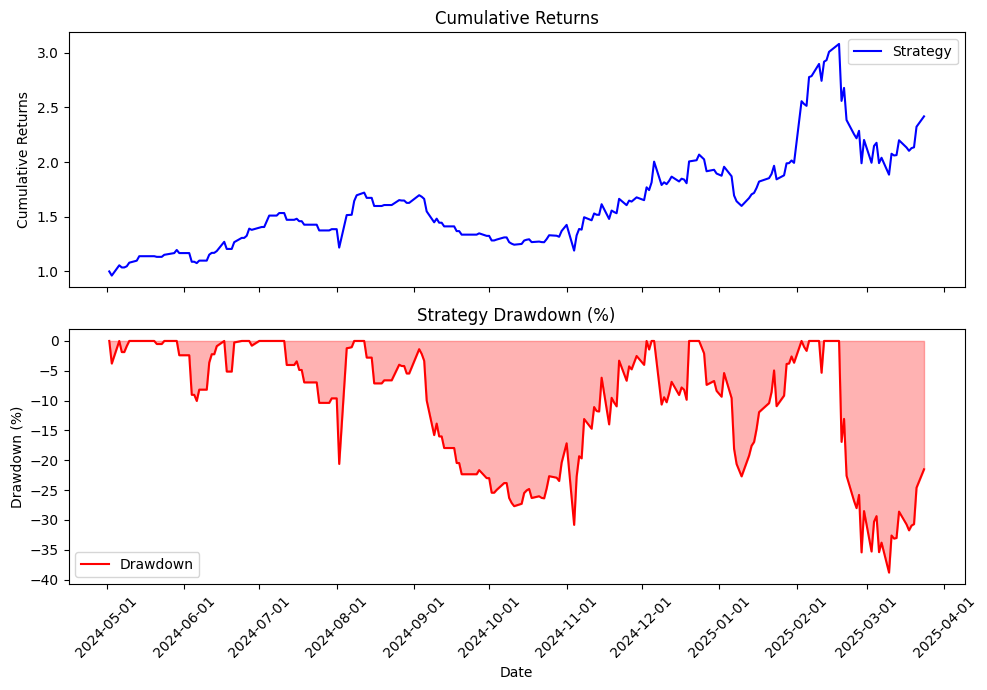

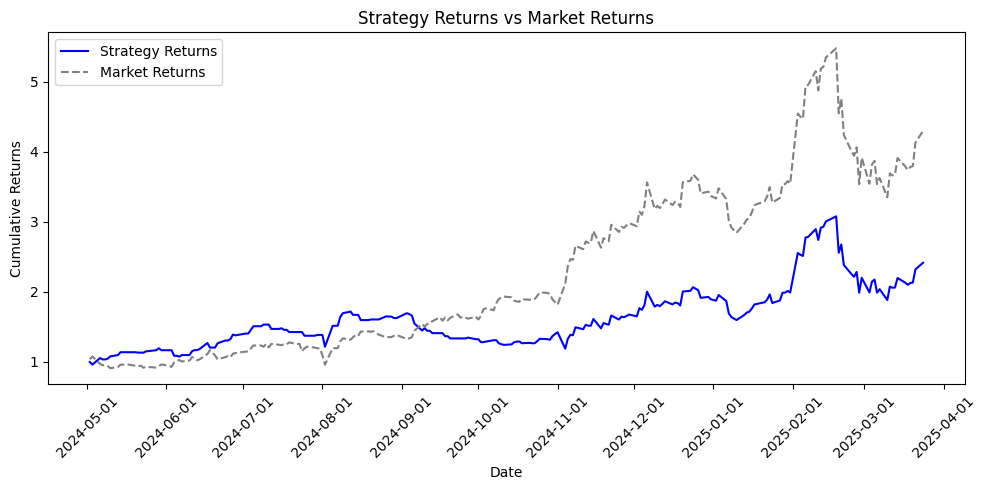

The strategy return is 141.81%


In [20]:
analyse_strategy(df_svc, test_index)